In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GroupKFold, GroupShuffleSplit
from sklearn.metrics import f1_score, make_scorer, roc_curve
import random

In [2]:
class featureMatrix(object):
    def __init__(self, mat, samples, features):
        self.mat = mat
        self.samples = np.array(samples)
        self.features = features
        
    def getMat(self):
        return(self.mat)
    
    def getSamples(self):
        return(self.samples)
    
    def getFeatures(self):
        return(self.features)
    
    def filterSamplesByName(self, samplesToInclude):
        include = [(x in samplesToInclude) for x in self.samples]
        self.mat = self.mat[include, :]
        self.samples = self.samples[include]
        
    def nSamples(self):
        return(len(self.samples))
    
    def getSampleSet(self, indices):
        return(featureMatrix(self.mat[indices, :], self.samples[indices,], self.features))

In [38]:
def getPhenotypeData(phenoType = ""):
    use_colnames = ['identifier', 'diagnosis']
    y = pd.read_csv("data/all_samples_filtered_labels.csv", usecols = use_colnames, index_col=0)
    y["diagnosis"] = np.where(y['diagnosis'] == 'Autism', 1, 0)
    return(y)

def getControlIds_Agre_Ssc():
    Agre_ctrl = pd.read_csv("data/v34_lof_typical_af0.50.txt", index_col=0).transpose()
    SSC_ctrl = pd.read_csv("data/SSC_lof_typical_af0.50.txt", index_col=0).transpose()
    X_ctrl = pd.concat([SSC_ctrl, Agre_ctrl], axis = 0).fillna(0)
    return(X_ctrl.index.values.tolist())

def getOverlappingSubjects(X, y, ped):
    subjects = list(set(y.index.values.tolist()) & set(X.getSamples())) #Get ids with gene and phenotype info
    
    #Add in ids that are implied controlled based on agre and ssc
    ctrl_ids = getControlIds_Agre_Ssc()
    to_add = set(ctrl_ids) - (set(subjects)) #throw ids that will already be included b/c they have explicit label
    y_ctrl = pd.DataFrame(np.zeros(len(to_add),), columns = ['diagnosis'],index = to_add)
    y = pd.concat([y, y_ctrl], axis = 0)
    subjects = subjects + list(to_add)
    
    #Filter data to include only selected samples
    X.filterSamplesByName(subjects) #include only samples present in provided list
    y = y.filter(items = subjects, axis = 0)
    y = y.reindex(X.getSamples()) #re-order to match gene info
    print("All subjects are equivalent in X and y sets: ", sum(y.index.values.tolist() == X.getSamples()) == X.nSamples())
    
    ped = ped.filter(items = subjects, axis = 0)
    ped = ped.reindex(X.getSamples())
    print("All subjects are equivalent in X and pedigree sets: ", sum(ped.index.values.tolist() == X.getSamples()) == X.nSamples())
    return(X, y, ped)
    
def getPedigree(pedType):
    if pedType == "agre":
        agre_ped = pd.read_csv("data/v34.vcf.ped", 
                sep = "\t", 
                usecols = [0,1])
        agre_ped.columns = ['fid','sibid']
        agre_ped = agre_ped.set_index('sibid')
        return(agre_ped)
        
    if pedType == "ssc":
        # read ssc ped 
        ssc_ped = pd.read_csv("data/ssc.ped", sep = "\t", header = None, usecols = [0,1])
        ssc_ped.columns = ['fid','sibid']
        ssc_ped = ssc_ped.set_index('sibid')
        return(ssc_ped)
       

def concatPedigrees(ped1, ped2):
    ped = pd.concat([ped1, ped2], axis = 0, ignore_index = False) 
    return(ped)
    
    
def getFeatureData(featType):
    
    if(featType == 'agre_ssc'):
        #Returns a np_array, sample list, and features list
        Agre_asd = pd.read_csv("data/v34_lof_asd_af0.50.txt", index_col=0).transpose()
        Agre_ctrl = pd.read_csv("data/v34_lof_typical_af0.50.txt", index_col=0).transpose()
        
        SSC_asd = pd.read_csv("data/SSC_lof_asd_af0.50.txt", index_col=0).transpose()
        SSC_ctrl = pd.read_csv("data/SSC_lof_typical_af0.50.txt", index_col=0).transpose()
        
        # merge SSC and Agre data
        X_asd = pd.concat([SSC_asd, Agre_asd], axis = 0).fillna(0)
        X_ctrl = pd.concat([SSC_ctrl, Agre_ctrl], axis = 0).fillna(0)

        X = np.concatenate([X_asd, X_ctrl], axis=0)
        samples = X_asd.index.values.tolist() + X_ctrl.index.values.tolist()
        features = X_asd.columns.values.tolist()
        
        X = featureMatrix(featMat, samples, features)
        return(X)
        
        
    if(featType == 'HAR'):
        #Returns a np_array , sample list, and features list, b/c memory constraints
        import os
        matrices = list()
        samples = []
        features = list()
        total = 0
        for file in os.listdir("data_iHart/HAR/"):
            if file.endswith(".npz"):
                file_path = os.path.join("data_iHart/HAR/", file)
                print(file_path)
                chrom = np.load(file_path)
                matrices.append(pd.DataFrame(chrom['binMatrix']))
                samples = [x.decode("ascii") for x in chrom['row_labels']] #Inefficient, but only need one set of sample ids
                features.append( chrom['col_labels'])
                
        featMat = np.concatenate(matrices, axis = 1)
        print 'Array Dimensions: ', featMat.shape
        print 'Size of Feature Matrix: ', np.prod(featMat.shape)
        print 'Number of Zeroes: ', (np.prod(featMat.shape)-np.count_nonzero(featMat))
        print 'Number of Ones: ', np.count_nonzero(featMat)
        percentage = ((float)(np.count_nonzero(featMat))/np.prod(featMat.shape))
        print 'Percentage of Ones: ', percentage
        features_unlist = [feat for chrom_featList in features for feat in chrom_featList]
        
        X = featureMatrix(featMat, samples, features_unlist)
        return(X)
                
        

    
    

In [39]:
X = getFeatureData(featType = "HAR")
y = getPhenotypeData()
ped = concatPedigrees(getPedigree('agre'), getPedigree('ssc'))

data_iHart/HAR/HAR_matrix_1.npz
data_iHart/HAR/HAR_matrix_10.npz
data_iHart/HAR/HAR_matrix_11.npz
data_iHart/HAR/HAR_matrix_12.npz
data_iHart/HAR/HAR_matrix_13.npz
data_iHart/HAR/HAR_matrix_14.npz
data_iHart/HAR/HAR_matrix_15.npz
data_iHart/HAR/HAR_matrix_16.npz
data_iHart/HAR/HAR_matrix_17.npz
data_iHart/HAR/HAR_matrix_18.npz
data_iHart/HAR/HAR_matrix_2.npz
data_iHart/HAR/HAR_matrix_20.npz
data_iHart/HAR/HAR_matrix_21.npz
data_iHart/HAR/HAR_matrix_22.npz
data_iHart/HAR/HAR_matrix_3.npz
data_iHart/HAR/HAR_matrix_4.npz
data_iHart/HAR/HAR_matrix_5.npz
data_iHart/HAR/HAR_matrix_6.npz
data_iHart/HAR/HAR_matrix_7.npz
data_iHart/HAR/HAR_matrix_8.npz
data_iHart/HAR/HAR_matrix_9.npz
data_iHart/HAR/HAR_matrix_X.npz
Array Dimensions:  (4608, 1962)
Size of Feature Matrix:  9040896
Number of Zeroes:  7946851
Number of Ones:  1094045
Percentage of Ones:  0.121010683012


In [5]:
X, y, ped = getOverlappingSubjects(X, y, ped)

('All subjects are equivalent in X and y sets: ', True)
('All subjects are equivalent in X and pedigree sets: ', True)


In [6]:
print("Number Control : ", sum(y['diagnosis'] == 0))
print("Number Cases: ", sum(y['diagnosis'] == 1))

('Number Control : ', 416)
('Number Cases: ', 2105)


Logistic Regression:
Now that we have gathered all the data we will need, let's split the data into a train and test set, and use k fold cross-validation on the train set to train a LR model and evaluate our results (once they're good) on the test set.

In [7]:
#Split groups into training and test, being careful about siblings from the same family in the same set
group_split = GroupShuffleSplit(test_size=.25, n_splits = 1) #25% test set

In [8]:
famid_strs = [str(x) for x in ped.loc[:, 'fid']]


In [9]:
for train_ind, test_ind in group_split.split(X.getMat(), y, famid_strs):
    train_ind = train_ind
    test_ind = test_ind
    
#Check that no family id's overlap
train_subj = X.getSamples()[train_ind]
test_subj = X.getSamples()[test_ind]
train_fid = [str(x) for x in ped.loc[train_subj, 'fid']]
test_fid = [str(x) for x in ped.loc[test_subj, 'fid']]

print("family ids that appear in both train and test set: ", set(train_fid).intersection(set(test_fid)))

X_train = X.getSampleSet(train_ind)
y_train = y.iloc[train_ind]
X_test = X.getSampleSet(test_ind)
y_test = y.iloc[test_ind]

('family ids that appear in both train and test set: ', set([]))


In [10]:
%reload_ext autoreload
%autoreload 2
from importlib import reload

ImportError: cannot import name reload


Running cross validation for fold 1:
Train Score: 0.884986 Test Score: 0.523565
('AU-ROC', 0.523565019997838)
('\nOptimum threshold to maximize training accuracy:', 0.68163472286734228)
('F1:', 0.87328244274809153)
('Accuracy:', 0.77984084880636606)
('Confusion Matrix:\n', array([[  8,  50],
       [ 33, 286]]))


/Users/mayavarma/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


('\nOptimum threshold to maximize f1:', 0.57577091679322834)
('F1:', 0.88955223880597012)
('Accuracy:', 0.80371352785145889)
('Confusion Matrix:\n', array([[  5,  53],
       [ 21, 298]]))
None


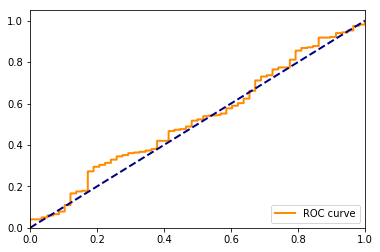


Running cross validation for fold 2:
Train Score: 0.872465 Test Score: 0.514248
('AU-ROC', 0.51424815983175598)
('\nOptimum threshold to maximize training accuracy:', 0.66130329775686181)
('F1:', 0.85403726708074534)
('Accuracy:', 0.75066312997347484)
('Confusion Matrix:\n', array([[  8,  52],
       [ 42, 275]]))
('\nOptimum threshold to maximize f1:', 0.58129232501738948)
('F1:', 0.88888888888888884)
('Accuracy:', 0.80371352785145889)
('Confusion Matrix:\n', array([[  7,  53],
       [ 21, 296]]))
None


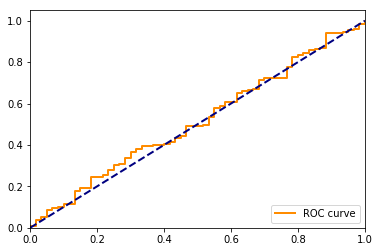


Running cross validation for fold 3:
Train Score: 0.873696 Test Score: 0.538762
('AU-ROC', 0.53876221498371335)
('\nOptimum threshold to maximize training accuracy:', 0.55855000528074805)
('F1:', 0.8553846153846153)
('Accuracy:', 0.75066312997347484)
('Confusion Matrix:\n', array([[  5,  65],
       [ 29, 278]]))
('\nOptimum threshold to maximize f1:', 0.55855000528074805)
('F1:', 0.8553846153846153)
('Accuracy:', 0.75066312997347484)
('Confusion Matrix:\n', array([[  5,  65],
       [ 29, 278]]))
None


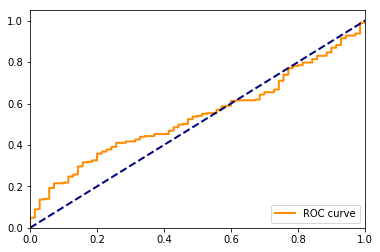


Running cross validation for fold 4:
Train Score: 0.882680 Test Score: 0.518501
('AU-ROC', 0.51850111303487512)
('\nOptimum threshold to maximize training accuracy:', 0.6611299004678155)
('F1:', 0.84772370486656201)
('Accuracy:', 0.74202127659574468)
('Confusion Matrix:\n', array([[  9,  56],
       [ 41, 270]]))
('\nOptimum threshold to maximize f1:', 0.65542499863811665)
('F1:', 0.85536547433903587)
('Accuracy:', 0.75265957446808507)
('Confusion Matrix:\n', array([[  8,  57],
       [ 36, 275]]))
None


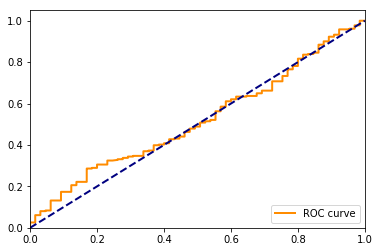


Running cross validation for fold 5:
Train Score: 0.887027 Test Score: 0.465209
('AU-ROC', 0.46520947176684879)
('\nOptimum threshold to maximize training accuracy:', 0.56180397185196029)
('F1:', 0.86328725038402454)
('Accuracy:', 0.76329787234042556)
('Confusion Matrix:\n', array([[  6,  55],
       [ 34, 281]]))
('\nOptimum threshold to maximize f1:', 0.56180397185196029)
('F1:', 0.86328725038402454)
('Accuracy:', 0.76329787234042556)
('Confusion Matrix:\n', array([[  6,  55],
       [ 34, 281]]))
None


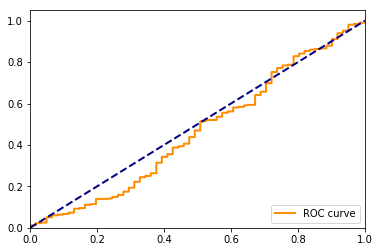

In [11]:
import class_EvalLR
from class_EvalLR import EvalLR
reload(class_EvalLR)

evalr = EvalLR(X_train, y_train, train_fid, reg = 'l1')
scores, topvals = evalr.kfold(5, True)

In [12]:
print (scores)
print ("Train:", np.mean(scores.Train_score))
print ("Test:", np.mean(scores.Test_score))

  Train_score Test_score
1    0.884986   0.523565
2    0.872465   0.514248
3    0.873696   0.538762
4     0.88268   0.518501
5    0.887027   0.465209
('Train:', 0.88017096477990342)
('Test:', 0.51205719592300636)


In [13]:
# create a plot of preformance versus f1 score for different c values
def reg_plot(c_vals, X_train, y_train, train_fid, resample = False):
    c_scores = []
    print( "Running 7-fold cross validation for:")
    for i in range(len(c_vals)):
        #print "C = %f" % c_vals[i]
        evalr = EvalLR(X_train, y_train, train_fid, reg = 'l1', c = c_vals[i])
        c_scores.append(np.mean(evalr.kfold(7, False, False, resample)[0].Test_score))

    plt.clf()
    plt.ylabel('Feature 2')
    plt.xlabel('Feature 1')
    plt.plot(c_vals, c_scores, linestyle = '-')
    plt.show()
    plt.figure(figsize=(10,10))
    return c_vals[c_scores.index(max(c_scores))]

Running 7-fold cross validation for:


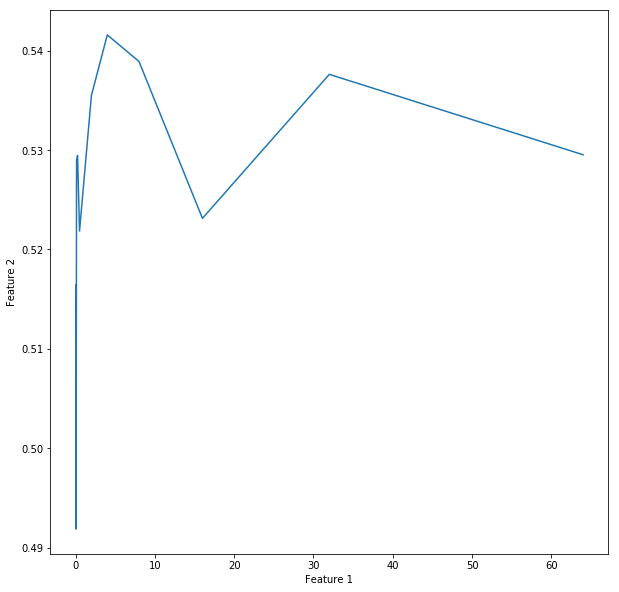

In [15]:
import class_EvalLR
from class_EvalLR import EvalLR
reload(class_EvalLR)
c_vals = [2**6, 2**5, 2**4, 2**3, 2**2, 2, 2**-1, 2**-2, 2**-3, 2**-4, 2**-5]
c_opt = reg_plot(c_vals, X_train, y_train, train_fid, resample = True)


Running cross validation for fold 1:
Train Score: 0.983833 Test Score: 0.495514
('AU-ROC', 0.49551399848665006)
('\nOptimum threshold to maximize training accuracy:', 0.6193425295147823)
('F1:', 0.86286594761171032)
('Accuracy:', 0.76392572944297077)
('Confusion Matrix:\n', array([[  8,  50],
       [ 39, 280]]))
('\nOptimum threshold to maximize f1:', 0.61829141276964983)
('F1:', 0.86286594761171032)
('Accuracy:', 0.76392572944297077)
('Confusion Matrix:\n', array([[  8,  50],
       [ 39, 280]]))
None


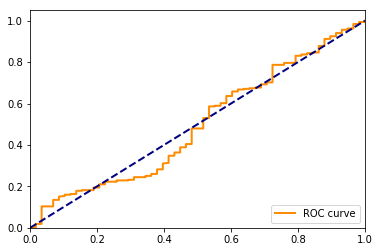


Running cross validation for fold 2:
Train Score: 0.980604 Test Score: 0.505521
('AU-ROC', 0.50552050473186116)
('\nOptimum threshold to maximize training accuracy:', 0.60351641416270618)
('F1:', 0.82240000000000002)
('Accuracy:', 0.70557029177718833)
('Confusion Matrix:\n', array([[  9,  51],
       [ 60, 257]]))
('\nOptimum threshold to maximize f1:', 0.60351641416270618)
('F1:', 0.82240000000000002)
('Accuracy:', 0.70557029177718833)
('Confusion Matrix:\n', array([[  9,  51],
       [ 60, 257]]))
None


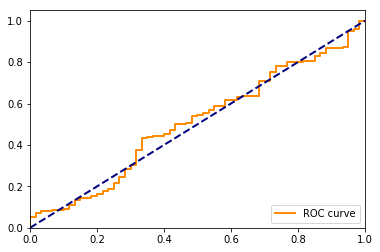


Running cross validation for fold 3:
Train Score: 0.983326 Test Score: 0.565496
('AU-ROC', 0.56549557933922756)
('\nOptimum threshold to maximize training accuracy:', 0.66123158051188435)
('F1:', 0.8039538714991763)
('Accuracy:', 0.68435013262599464)
('Confusion Matrix:\n', array([[ 14,  56],
       [ 63, 244]]))
('\nOptimum threshold to maximize f1:', 0.65477840728929892)
('F1:', 0.80592105263157898)
('Accuracy:', 0.6870026525198939)
('Confusion Matrix:\n', array([[ 14,  56],
       [ 62, 245]]))
None


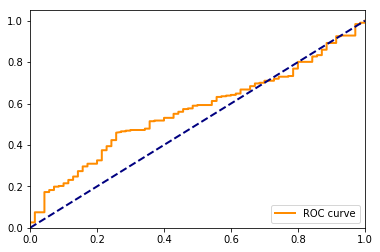


Running cross validation for fold 4:
Train Score: 0.984474 Test Score: 0.534430
('AU-ROC', 0.53442987880286918)
('\nOptimum threshold to maximize training accuracy:', 0.61358553022939966)
('F1:', 0.83840000000000003)
('Accuracy:', 0.7313829787234043)
('Confusion Matrix:\n', array([[ 13,  52],
       [ 49, 262]]))
('\nOptimum threshold to maximize f1:', 0.61358553022939966)
('F1:', 0.83840000000000003)
('Accuracy:', 0.7313829787234043)
('Confusion Matrix:\n', array([[ 13,  52],
       [ 49, 262]]))
None


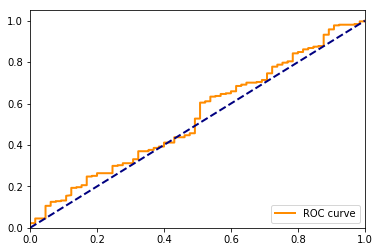


Running cross validation for fold 5:
Train Score: 0.983241 Test Score: 0.497632
('AU-ROC', 0.497632058287796)
('\nOptimum threshold to maximize training accuracy:', 0.61853433192449414)
('F1:', 0.82125603864734309)
('Accuracy:', 0.70478723404255317)
('Confusion Matrix:\n', array([[ 10,  51],
       [ 60, 255]]))
('\nOptimum threshold to maximize f1:', 0.61853433192449414)
('F1:', 0.82125603864734309)
('Accuracy:', 0.70478723404255317)
('Confusion Matrix:\n', array([[ 10,  51],
       [ 60, 255]]))
None


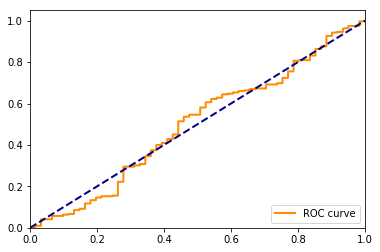

In [16]:
evalr = EvalLR(X_train, y_train, train_fid, reg = 'l1', c = c_opt)
scores, topgenes = evalr.kfold(5, True)

In [17]:
print (scores)
print ("Train:", np.mean(scores.Train_score))
print ("Test:", np.mean(scores.Test_score))

  Train_score Test_score
1    0.983833   0.495514
2    0.980604   0.505521
3    0.983326   0.565496
4    0.984474    0.53443
5    0.983241   0.497632
('Train:', 0.98309547359013738)
('Test:', 0.51971840392968072)


Next step to try will be a combination of coding and non-coding space